_version log: Anti-chirping fails when the x^3 coeffient is negative. Need to apply a contraint._

In [177]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import os, re
from scipy import interpolate, signal as scisig
from scipy.optimize import curve_fit
from scipy.ndimage import median_filter
plt.rcParams.update({'font.size':14})

c = 299_792_458
source = "ir" # "blue" "green" "red" "FBH800" "FBH1600" "ir"
run = "16"
camera = "xeva" #"xeva" for importing .csv files, "manta" for importing .tif
anti_chirping = True #True for applying Elin's anti-chirping code.
zero_padding = True #extrapolate the interferogram. This should interpolate the spectrum rather than improving resolution.
apodization_function = None # None and "box" do the same thing. Also try "triangular", "happ-genzel", "blackmann-harris"
angle_calculation_method = "delay" # "manual" for a known angle (ie. measured with ruler), "wavelength" for calibration with a known wavelength or "delay" for calulation using a temporal change on the delay line.
angle_between_beams = 0.1 #degrees. Used if angle_calculation_method == "manual"
delay_line_delta = 2 #um. Distance traveled by delay line between each reading. Used if angle_calculation_method == "delay"
calibration_wavelength = 1.6 #um. Used if angle_calculation_method == "wavelength"

if camera == "manta":
    pixel_pitch = 9.9 #um
elif camera == "xeva":
    pixel_pitch = 20 #um

In [178]:
#################FUNCTIONS##################

def line(x,m,k):
    return m*x+k

def cubic(x,A,B,C,D):
     return A + B*x + C*x**2 + D*x**3

def apodization(interferogram, function = None):
     if function == None or function == "box":
          return interferogram
     
     L = len(interferogram) # window width
     index = np.arange(0, L) # We need indexes if we want to apply apodization

     if function == "triangular":
          return interferogram * (1-np.abs(2*index/L -1))
     if function == "happ-genzel":
          return interferogram * (0.54 +0.46*np.sin(np.pi*index/L))
     if function == "blackmann-harris":
          return interferogram * (0.42323 +0.49755*np.sin(np.pi*index/L) +0.07922*np.sin(2*np.pi*index/L))
          


#Elin's anti-chirping function
def regularspacing(calibration, interferogram): #calibration intensities, interferogram intensities
    calibrationsmooth = median_filter(calibration, 2) #reduces noise and dead pixels
    calibration_index = np.arange(ROI[0], ROI[1]) #create indexes for calibration.
    constructive_locs, _ = scisig.find_peaks(calibrationsmooth) #locations of the contractive interferance.
    destructive_locs, _ = scisig.find_peaks(-calibrationsmooth) #locations of the destructive interferance.
    fringe_locs = np.concatenate([constructive_locs, destructive_locs])
    fringe_locs = np.sort(fringe_locs)
    fringe_locs += ROI[0]

    liniar_locs = np.linspace(fringe_locs[0], fringe_locs[-1], len(fringe_locs)) #liniarly spaced version of the fringe locations

    coeffs, _ = curve_fit(cubic, liniar_locs, fringe_locs, p0=[0,1,0,0], bounds= ([-np.inf, -np.inf, -np.inf, 0], np.inf))
    p = np.polynomial.Polynomial(coeffs)

    liniar_index = p(calibration_index) #liniarise the indexes
    unchirped_intensity = np.interp(calibration_index, liniar_index, calibration) #map the indexes to the interferogram using liniar interpolation where nessisary.

    interferogram_index = np.arange(0, len(interferogram))
    extra_liniar_index = p(interferogram_index) #liniarise the indexes
    extra_unchirped_intensity = np.interp(interferogram_index, extra_liniar_index, interferogram) #map the indexes to the interferogram using liniar interpolation where nessisary.

    plt.figure(figsize= (12,6))

    plt.subplot(1,2,1)
    plt.plot(fringe_locs, liniar_locs, marker= "x", linestyle = "None", label= "sampled points")
    plt.plot(interferogram_index, extra_liniar_index, label = "({0:.1e})+({1:.1e})x\n+({2:.1e})x$^2$+({3:.1e})x$^3$".format(*coeffs))
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(interferogram)
    plt.plot(extra_unchirped_intensity)
    plt.vlines(ROI, np.min(interferogram), np.max(interferogram), color = "k")
    plt.show()

    return unchirped_intensity, extra_unchirped_intensity # unchirped intensities, extrapolated unchirped intensities

def import_standard_photo(colour, number):
    if camera == "manta":
        im = Image.open('data\\'+colour+'_fringes'+number+'.tif')
        fringes = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_BA'+number+'.tif')
        beamA = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_BB'+number+'.tif')
        beamB = np.array(im, dtype= np.float32)
        im = Image.open('data\\'+colour+'_bg'+number+'.tif')
        background = np.array(im, dtype= np.float32)
    elif camera == "xeva":
         fringes = np.loadtxt('data\\'+colour+'_fringes'+number+'.csv', delimiter=";")
         beamA = np.loadtxt('data\\'+colour+'_BA'+number+'.csv', delimiter=";")
         beamB = np.loadtxt('data\\'+colour+'_BB'+number+'.csv', delimiter=";")
         background = np.loadtxt('data\\'+colour+'_bg'+number+'.csv', delimiter=";")
    return fringes, beamA, beamB, background

def find_angle_files(colour, number):
    file_names = os.listdir("data\\")
    new_file_names=[]
    new_file_numbers=[]
    for file_name in file_names:
        if camera == "manta":
            check = re.findall(colour+'_fringes'+number+'_[0-9]+.tif' , file_name)
        elif camera == "xeva":
            check = re.findall(colour+'_fringes'+number+'_[0-9]+.csv' , file_name)
        if len(check) != 0:
            new_file_names = new_file_names + [file_name]

            file_number = re.findall('[0-9]+' , file_name)
            new_file_numbers = new_file_numbers + [int(file_number[-1]) -1] #the number that we are looking for is always the last number in the file name
    df = pd.DataFrame(np.transpose([new_file_names, new_file_numbers]), columns= ["file names", "file numbers"])
    df["file numbers"] = [int(number) for number in df["file numbers"]] #pandas forgot that numbers are intergers
    df = df.sort_values("file numbers", ignore_index= True) #I still don't know how to sort values using a key with numpy
    return df["file names"], df["file numbers"]

def combine_angle_arrays(file_names):
    if camera == "manta":
        im = Image.open('data\\'+file_names[0]) #for the first interferogram
        angles = np.array(im, dtype= np.float32)
        for file_name in file_names[1:]: #for every other interferogram
            im = Image.open('data\\'+file_name)
            Array = np.array(im, dtype= np.float32)
            angles = np.dstack([angles,Array])
    elif camera == "xeva":
        angles = np.loadtxt('data\\'+file_names[0], dtype= np.float32, delimiter=";")
        for file_name in file_names[1:]: #for every other interferogram
            Array = np.loadtxt('data\\'+file_name, dtype= np.float32, delimiter=";")
            angles = np.dstack([angles,Array])

    return angles

def process_fringes(fringes, beamA, beamB, background):
    if fringes.ndim == 3:
        nofringes = np.dstack([beamA +beamB -background] *fringes.shape[2]) #This will throw an error if fringes is 2d
    elif fringes.ndim == 2:
        nofringes = beamA +beamB -background #ignore the error

    beamPost = fringes - nofringes #take away background.
    beamPost -= np.mean(beamPost)

    return beamPost, nofringes

def apply_cross_corrlations(angle_averages, referenace_signal):
        
        if angle_averages.ndim == 1:
            cross_corr = scisig.correlate(referenace_signal, angle_averages, mode='same') #use average_signal as a referance to find the displacements.
            lags = scisig.correlation_lags(len(referenace_signal), len(angle_averages), mode="same")
            displacements = lags[np.argmax(cross_corr)] #*pixel_pitch #convert from indexes to um.

        elif angle_averages.ndim == 2:
            cross_corr = scisig.correlate(referenace_signal, angle_averages[:,0], mode='same') #use average_signal as a referance to find the displacements.
            lags = scisig.correlation_lags(len(referenace_signal), len(angle_averages[:,0]), mode="same")
            displacements = lags[np.argmax(cross_corr)] #*pixel_pitch #convert from indexes to um.

            for n in np.arange(1,angle_averages.shape[1]): #for every other interferogram
                    cross_corr = scisig.correlate(angle_averages[:,n], referenace_signal, mode='same') #use average_signal as a referance to find the displacements.
                    lags = np.arange(0, len(referenace_signal), 1)
                    displacement = lags[np.argmax(cross_corr)] #*pixel_pitch #convert from indexes to um.
                    displacements = np.hstack([displacements,displacement])

        return displacements, cross_corr

def Coeffients2Amplitudes(FT, freqs):
        samples = len(FT)
        num_of_freqs = len(FT)//2 +1
        amplitude = np.zeros(num_of_freqs)
        amplitude[0] = np.abs(FT[0])
        if (samples//2 == samples/2): #if even
                amplitude[-1] = np.abs(FT[num_of_freqs-1])
                amplitude[1:-2] = (np.abs( FT[1:num_of_freqs-2] ) +
                                np.abs( FT[:num_of_freqs:-1] ))

                wavelengths = 1/freqs[:num_of_freqs]
                freqs = freqs[:num_of_freqs]
        else: #if odd
                amplitude[1:] = (np.abs( FT[1:num_of_freqs] ) +
                                np.abs( FT[:num_of_freqs-1:-1] ))
                wavelengths = 1/freqs[:num_of_freqs]
                freqs = freqs[:num_of_freqs]
        return amplitude, wavelengths, freqs

def import_normalised_csv(file_name, start_row):
    File = open('data\\'+file_name, 'rt')
    array = np.loadtxt(File, skiprows=start_row, delimiter = ",")
    File.close()
    array[:,1] = array[:,1] / np.max(array[:,1]) #normalise
    return array

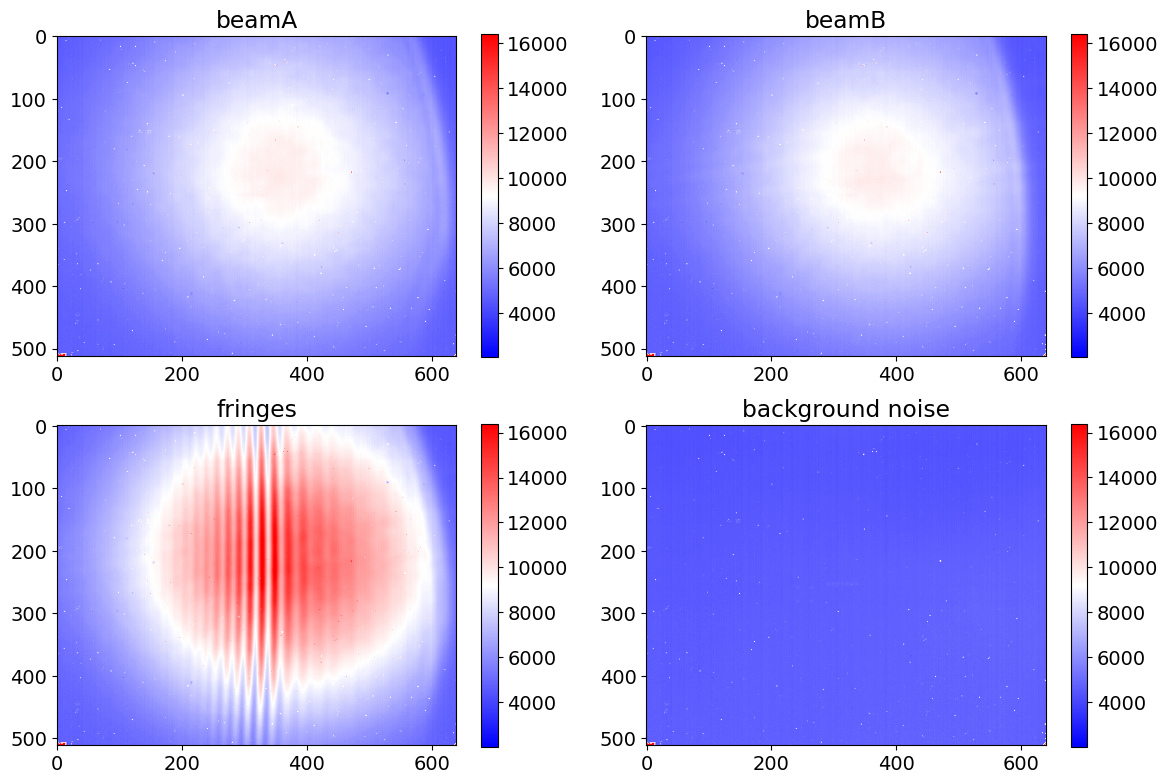

In [179]:
fringes, beamA, beamB, background = import_standard_photo(source, run)

plt.figure(figsize= (12,8))

plt.subplot(2,2,1)
im=plt.imshow(beamA, cmap='bwr')
plt.colorbar(im)
plt.title("beamA")

plt.subplot(2,2,2)
im=plt.imshow(beamB, cmap='bwr')
plt.colorbar(im)
plt.title("beamB")

plt.subplot(2,2,3)
im=plt.imshow(fringes, cmap='bwr')
plt.colorbar(im)
plt.title("fringes")

plt.subplot(2,2,4)
im=plt.imshow(background, cmap='bwr')
plt.colorbar(im)
plt.title("background noise")

plt.tight_layout()
plt.show()

In [180]:
beamPost, nofringes = process_fringes(fringes, beamA, beamB, background)
average_signal = np.mean(beamPost, axis = 0)

Start index of FWHM: 224
End index of FWHM: 405


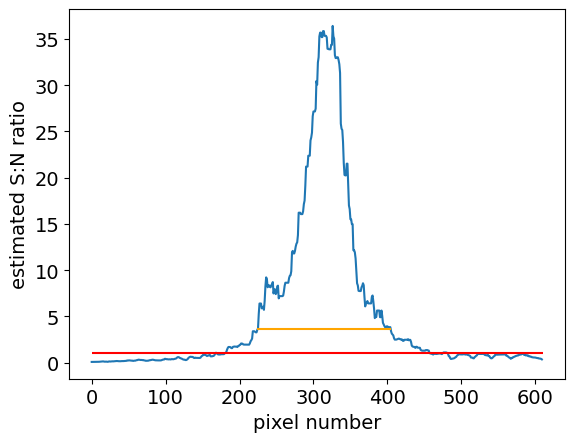

In [181]:
window_width = 30 #should be at least 1 period

# I've defined the signal as the differnence between the peaks and the troughs of the processed interferogram.
signal = np.array([np.diff(np.percentile(np.mean(beamPost, axis = 0)[n:n+window_width], [10,90]))[0] for n in np.arange(0, len(average_signal)-window_width)])
# I've defined the noise as the differance between the peaks and troughs of the background image. THIS IS NOT A GREAT ESTIMATION BECAUSE THE BACKGROUND IS NOT UNIFORM.
noise = np.array([np.diff(np.percentile(np.mean(background, axis = 0)[n:n+window_width], [10,90]))[0] for n in np.arange(0, len(average_signal)-window_width)])

S2N = signal / noise

# OpenAI did this bit for me. It finds a range of high S2N data.
S2N_threshold = np.max(S2N) / 10
max_index = np.argmax(S2N)
left_idx = np.where(S2N[:max_index] <= S2N_threshold)[0][-1]
right_idx = np.where(S2N[max_index:] <= S2N_threshold)[0][0] + max_index

ROI = [left_idx +window_width//2, right_idx +window_width//2]

print("Start index of FWHM:", left_idx)
print("End index of FWHM:", right_idx)

plt.plot(S2N)
plt.ylabel("estimated S:N ratio")
plt.xlabel("pixel number")
plt.hlines([1, S2N_threshold], [0, left_idx], [len(signal), right_idx], color = ["red","orange"])
plt.show()

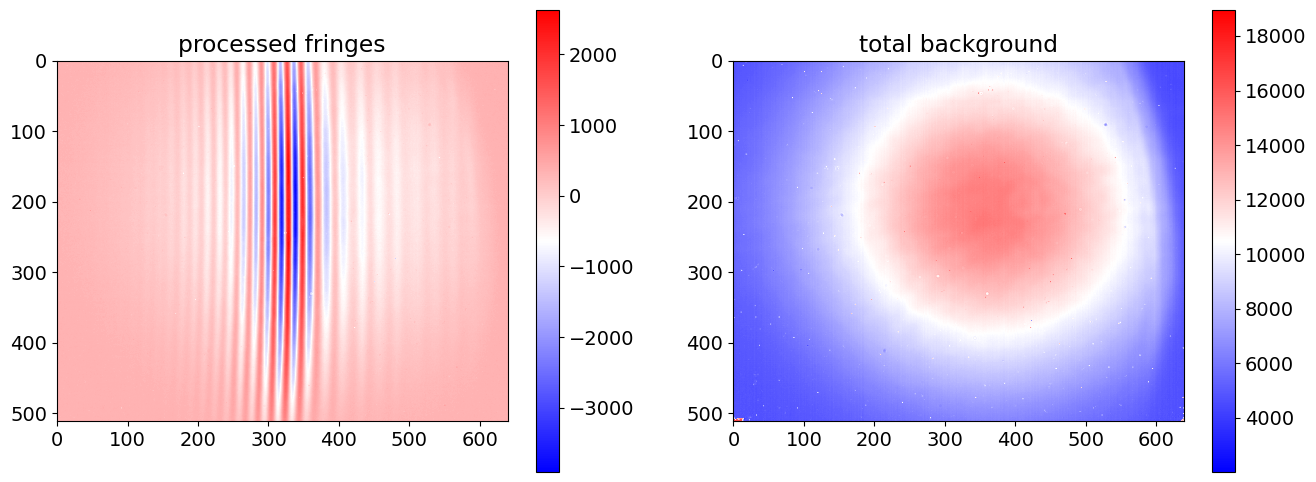

In [182]:
plt.figure(figsize = (16,6))

ax = plt.subplot(1,2,1)
im=plt.imshow(beamPost, cmap='bwr')
plt.colorbar(im)
plt.title("processed fringes")

plt.subplot(1,2,2)
im=plt.imshow(nofringes, cmap='bwr')
plt.colorbar(im)
plt.title("total background")

plt.show()

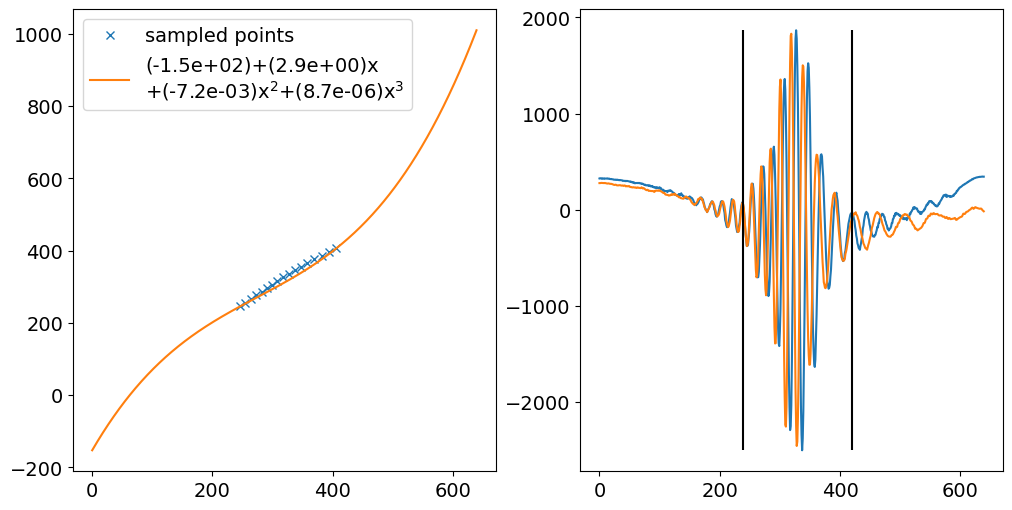

In [183]:
if anti_chirping == True:
    test, average_signal2 = regularspacing(average_signal[ROI[0]:ROI[1]], average_signal)
else:
    average_signal2 = average_signal

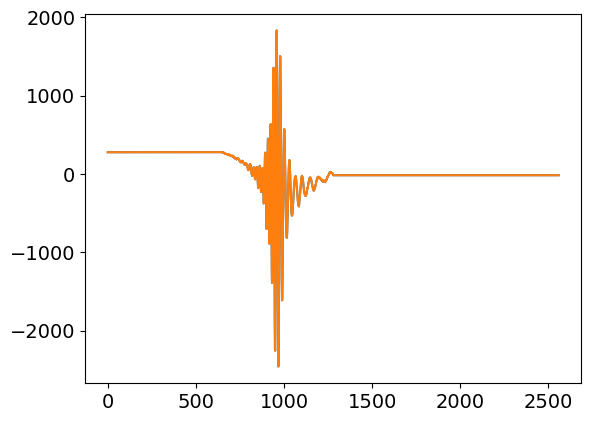

In [184]:
if zero_padding == True:
    average_signal2 = np.concatenate([[average_signal2[0]] *len(average_signal2), average_signal2])
    average_signal2 = np.concatenate([average_signal2, [average_signal2[-1]] *len(average_signal2)])

plt.plot(average_signal2)
average_signal2 = apodization(average_signal2, function = apodization_function)
plt.plot(average_signal2)
plt.show()

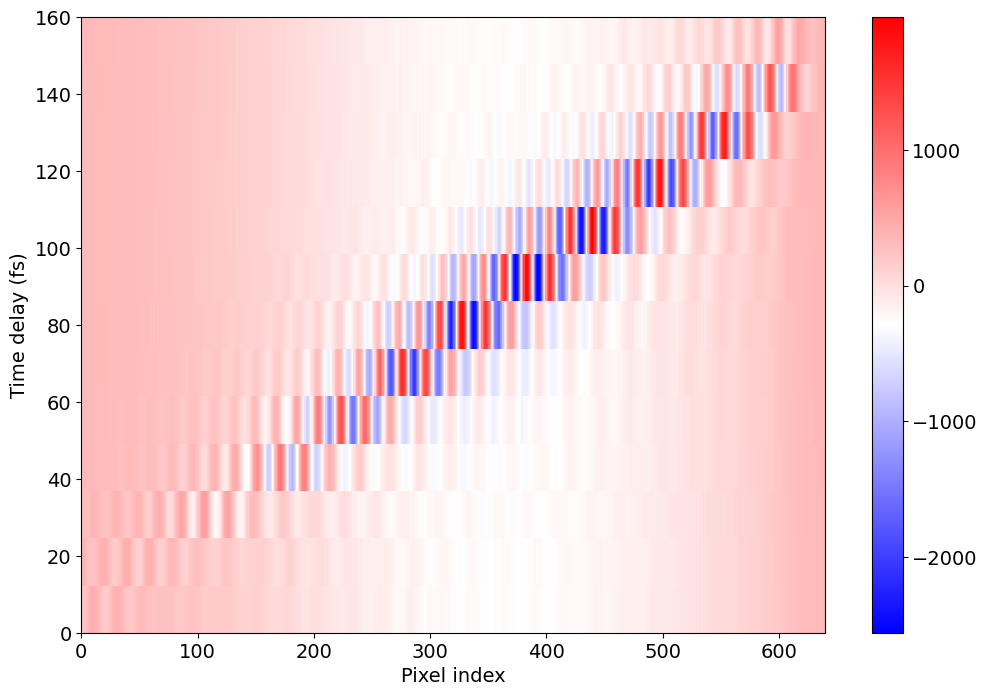

In [185]:
if angle_calculation_method == "delay":
    file_names, file_numbers = find_angle_files(source, run)
    angles = combine_angle_arrays(file_names)
    angles, _ = process_fringes(angles, beamA, beamB, background)
    angle_averages = np.mean(angles, axis = 0)
    

    delay_line_travel = np.arange(angle_averages.shape[1]) *delay_line_delta
    time_delay = delay_line_travel *2 /c
    time_delay *= 1e9 #convert from us to fs

    plt.figure(figsize = (12,8))

    ax = plt.subplot(1,1,1)
    im=plt.imshow(np.transpose(angle_averages), 
                cmap='bwr', 
                aspect = "auto", 
                interpolation = "none", #"none" and "nearest" are the only physical ones
                origin = "lower", 
                extent=[0,angle_averages.shape[0],0,time_delay[-1]])
    plt.colorbar(im)
    plt.xlabel("Pixel index")
    plt.ylabel("Time delay (fs)")

    plt.show()

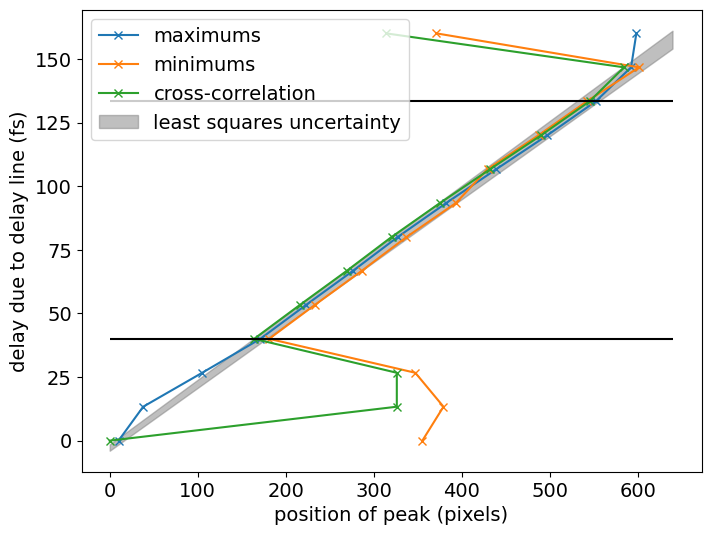

In [186]:
if angle_calculation_method == "delay":
        delay_line_bounds = [3,-3] #As the fringes move outside of the ROI, the peak position becomes inaccurate.

        maximums = np.argmax(angle_averages, axis = 0)
        minimums = np.argmin(angle_averages, axis = 0)
        cross_corr, _ = apply_cross_corrlations(angle_averages, average_signal)
        # elin uses scipy.signal.find_peaks. IDK which meathod is better

        all_peak_estimates = np.concatenate((maximums[delay_line_bounds[0]:delay_line_bounds[1]], minimums[delay_line_bounds[0]:delay_line_bounds[1]], cross_corr[delay_line_bounds[0]:delay_line_bounds[1]]))
        time_delays = list(time_delay[delay_line_bounds[0]:delay_line_bounds[1]])*3

        popt, pcov = curve_fit(line, all_peak_estimates, time_delays)
        m = popt[0]
        k = popt[1]
        err_m = np.sqrt(pcov[0][0]) /m #make into percentage error
        err_k = np.sqrt(pcov[1][1]) /k


        fig, axs = plt.subplots(figsize = (8,6)) #subplots defults to only plotting 1 subplot.

        plt.plot(maximums,
                time_delay,
                label = "maximums",
                marker = "x")
        plt.plot(minimums,
                time_delay,
                label = "minimums",
                marker = "x")
        plt.plot(cross_corr,
                time_delay,
                label = "cross-correlation",
                marker = "x")
        x = np.arange(0, len(average_signal))
        axs.fill_between(x,
                        line(x, m*(1-err_m), k*(1-err_k)),
                        line(x, m*(1+err_m), k*(1+err_k)),
                        color = "gray",
                        alpha = 0.5,
                        label = "least squares uncertainty")

        plt.hlines([time_delay[delay_line_bounds[0]],time_delay[delay_line_bounds[1]]], 0, len(average_signal), color = "k")
        plt.ylabel('delay due to delay line (fs)')
        plt.xlabel('position of peak (pixels)')
        plt.legend()

        plt.show()

In [187]:
if angle_calculation_method == "delay":
    print("gradient = {0:.2e} +/- {1:.1e} ".format(m, err_m*m) + "fs/pixel")

    m /= 1e9 *pixel_pitch #convert the gradient from fs/pixel to um/us (= m/s)
    theta = np.arcsin(c *np.abs(m) /2 ) 
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    err_angle = angle_between_beams *np.abs(err_m) #relies on the small angle appoximation. This is an underestimate.
    print("angle between beams = {0:.3f} +/- {1:.3f}° or {2:.1f} +/- {3:.1f} arcminutes".format(angle_between_beams, 2*err_angle, 60*angle_between_beams, 60*2*err_angle))

gradient = 2.51e-01 +/- 3.6e-03 fs/pixel
angle between beams = 0.216 +/- 0.006° or 12.9 +/- 0.4 arcminutes


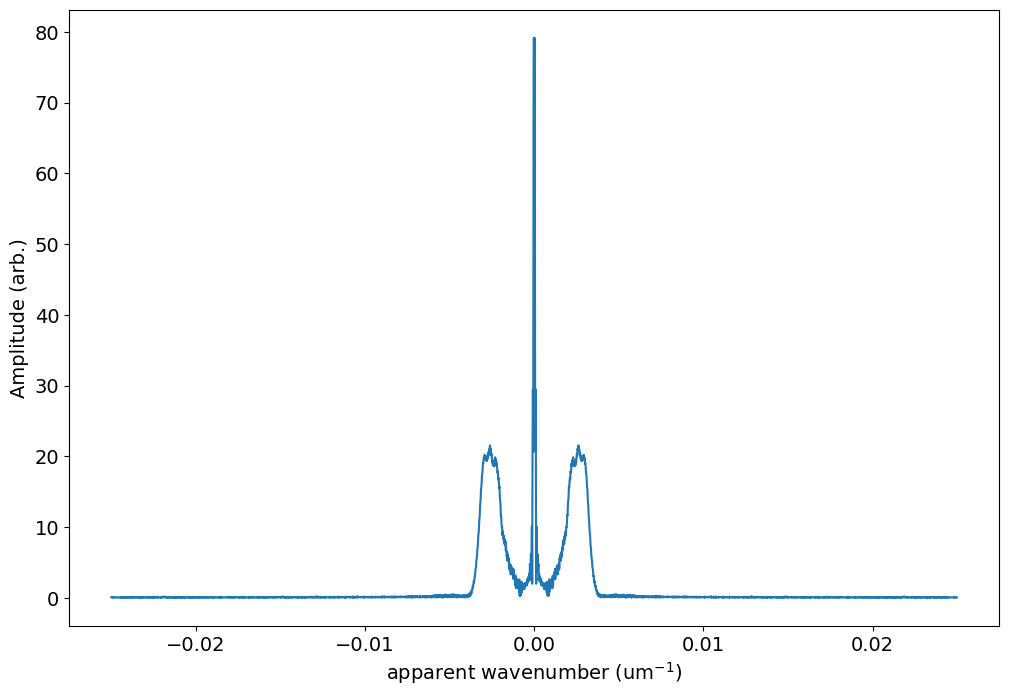

In [188]:
FT = np.fft.fft(average_signal2, norm = "forward")

num_of_freqs = len(FT)//2 +1
samples = len(FT)
freqs = np.fft.fftfreq(len(FT), pixel_pitch)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(np.fft.fftshift(freqs), #plt works best when the data set is in order
        np.fft.fftshift(abs(FT)))

plt.xlabel('apparent wavenumber (um$^{-1}$)')
plt.ylabel('Amplitude (arb.)')

plt.show()

C:\Users\syf83691\AppData\Local\Temp\ipykernel_18592\2560104866.py:155: RuntimeWarning: divide by zero encountered in divide
  wavelengths = 1/freqs[:num_of_freqs]


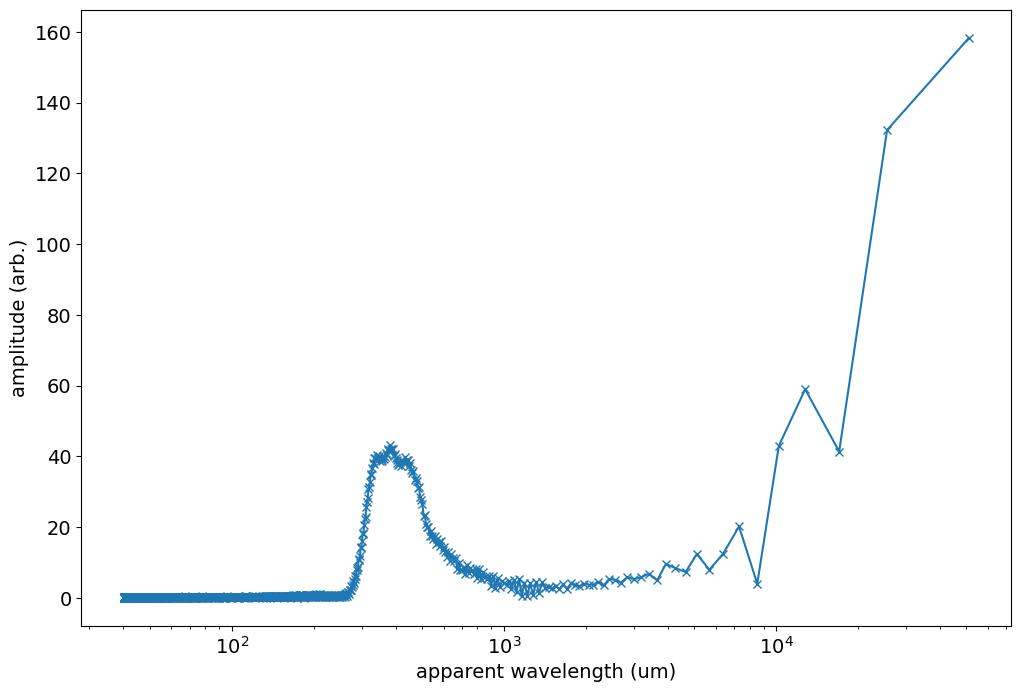

In [189]:
amplitude = np.zeros(num_of_freqs)
amplitude[0] = np.abs(FT[0])
amplitude, wavelengths, freqs = Coeffients2Amplitudes(FT, freqs)

plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(wavelengths[:-1], #excule the infinate wavelength
        amplitude[:-1],
        marker = "x")
plt.xlabel('apparent wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.show()

In [190]:
################COMPENSATE FOR ANGLE#################
if angle_calculation_method == "manual":
    theta = angle_between_beams/2 *np.pi/180
if angle_calculation_method == "wavelength":
    theta = np.arcsin(calibration_wavelength /2 /wavelengths[np.argmax(amplitude)])
    angle_between_beams = 2 *theta *180/np.pi #convert from radians to degrees
    print("angle between beams = {0:.3f}° or {1:.1f} arcminutes".format(angle_between_beams, 60*angle_between_beams))

corrected_wavelengths = wavelengths *2*np.sin(theta)

###################CREATING AN EXPECTED SPECTRUM USING MANUFACURER DATA################## #I made a mess here. Pls clean up.

amplitude = amplitude /np.nanmax(amplitude[:-1]) #normalise

camera_data = import_normalised_csv("mantra_spectrum.csv", 0)
camera_data[:,0] *= 1e-3 #convert to um
camera_function = interpolate.interp1d(camera_data[:,0], camera_data[:,1], fill_value= 0, bounds_error= False)

source_data = import_normalised_csv("SLS201L_spectrum.csv", 1)
source_data[:,0] *= 1e-3 #convert to um
source_function = interpolate.interp1d(source_data[:,0], source_data[:,1], fill_value= 0, bounds_error= False) #Also try fill_value= np.nan

mirror = import_normalised_csv("unprotected_gold_mirror_spectrum.csv", 1)
mirror_function = interpolate.interp1d(mirror[:,0], mirror[:,1], fill_value= 0, bounds_error= False)

def manufacturers_function(x):
        return (mirror_function(x) *
                source_function(x)**(source == "ir") * #source_function if true, 1 if false. I'm kinda proud of this. I think it's a neat solution.
                camera_function(x)**(camera == "manta"))

percentagediff = (manufacturers_function(corrected_wavelengths[:-1]) - amplitude[:-1]) /amplitude[:-1]
amplitude *= np.nanmin(percentagediff[percentagediff != -1]) +1 #re-scale to fit

normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1]) #factor in the camera sensitivity

C:\Users\syf83691\AppData\Local\Temp\ipykernel_18592\689476327.py:31: RuntimeWarning: invalid value encountered in divide
  percentagediff = (manufacturers_function(corrected_wavelengths[:-1]) - amplitude[:-1]) /amplitude[:-1]
C:\Users\syf83691\AppData\Local\Temp\ipykernel_18592\689476327.py:34: RuntimeWarning: divide by zero encountered in divide
  normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1]) #factor in the camera sensitivity
C:\Users\syf83691\AppData\Local\Temp\ipykernel_18592\689476327.py:34: RuntimeWarning: invalid value encountered in divide
  normalised_amplitude = amplitude[:-1] / camera_function(corrected_wavelengths[:-1]) #factor in the camera sensitivity


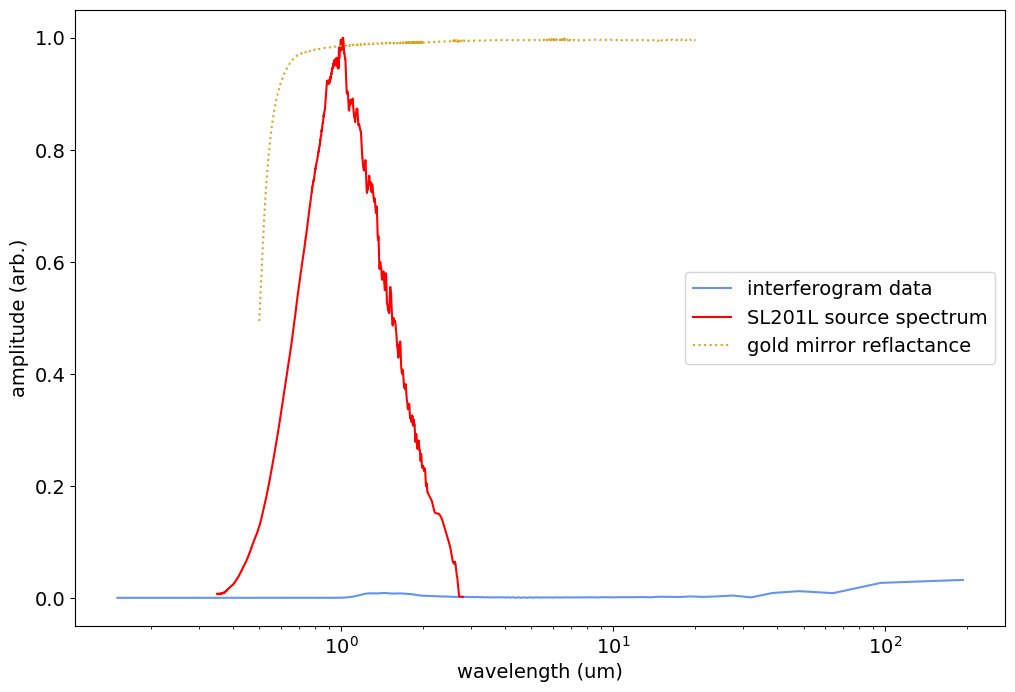

1281


In [191]:
plt.figure(figsize = (12,8))
plt.subplot(1, 1, 1)

plt.plot(corrected_wavelengths[:-1], #excule the infinate wavelength and convert to nm
        amplitude[:-1],
        label = "interferogram data",
        color = "cornflowerblue")
if camera == "manta":
        plt.plot(camera_data[:,0],
                camera_data[:,1],
                label = "Manta camera spectral responce",
                color = "orange",
                linestyle = "--")
        plt.plot(corrected_wavelengths[:-1], #excule the infinate wavelength and convert to nm
                normalised_amplitude,
                label = "normalised interferogram data",
                color = "blue")
if source == "ir":
        plt.plot(source_data[:,0],
                source_data[:,1],
                label = "SL201L source spectrum",
                color = "red")
        plt.plot(mirror[:,0],
                mirror[:,1],
                label = "gold mirror reflactance",
                color = "goldenrod",
                linestyle = ":")
elif angle_calculation_method == "wavelength":
        try:
                plt.axvline(calibration_wavelength, color = source)
        except ValueError:
                plt.axvline(calibration_wavelength, color = "k")
plt.xlabel('wavelength (um)')
plt.ylabel('amplitude (arb.)')
plt.xscale("log")
plt.legend()
plt.show()

print(len(corrected_wavelengths))